In [2]:
import medmnist
from medmnist import INFO, Evaluator

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms import v2

In [4]:
import matplotlib.pyplot as plt

# PathMnist

## Size 28

In [5]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    #transforms.ToTensor(),
    v2.PILToTensor()
    #transforms.Resize(224)
    #transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jbinda/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/jbinda/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/jbinda/.medmnist/pathmnist.npz


In [7]:
print(train_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/jbinda/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-

In [8]:
len(train_dataset)

89996

In [9]:
train_dataset[0][0]

tensor([[[220, 219, 220,  ..., 220, 219, 221],
         [218, 220, 219,  ..., 197, 192, 190],
         [220, 220, 219,  ..., 208, 207, 209],
         ...,
         [218, 217, 221,  ..., 221, 220, 221],
         [213, 217, 221,  ..., 221, 221, 221],
         [215, 220, 221,  ..., 220, 221, 222]],

        [[208, 207, 207,  ..., 208, 207, 208],
         [206, 207, 206,  ..., 177, 172, 168],
         [208, 207, 205,  ..., 191, 192, 194],
         ...,
         [205, 201, 208,  ..., 208, 208, 209],
         [192, 200, 208,  ..., 208, 209, 208],
         [195, 207, 208,  ..., 208, 208, 209]],

        [[227, 227, 227,  ..., 227, 227, 227],
         [226, 226, 226,  ..., 202, 197, 195],
         [226, 226, 225,  ..., 213, 213, 216],
         ...,
         [225, 222, 227,  ..., 227, 227, 227],
         [218, 222, 227,  ..., 227, 227, 227],
         [220, 226, 227,  ..., 227, 227, 228]]], dtype=torch.uint8)

In [12]:
imgs=[]
for i in range(len(train_dataset)):
    imgs.append(train_dataset[i][0])
imgs = torch.stack(imgs)
mean = torch.mean(imgs, dim=(0,2,3))
std = torch.std(imgs, dim=(0,2,3))

In [13]:
imgs.shape

torch.Size([89996, 3, 28, 28])

In [14]:
mean = torch.mean(imgs, dim=(0,2,3))

In [15]:
mean

tensor([0.7405, 0.5330, 0.7058])

In [16]:
std

tensor([0.1237, 0.1768, 0.1244])

In [16]:
batch = next(iter(train_loader))

In [17]:
example = batch[0][0,:,:]
example = torch.movedim(example, 0, 2)

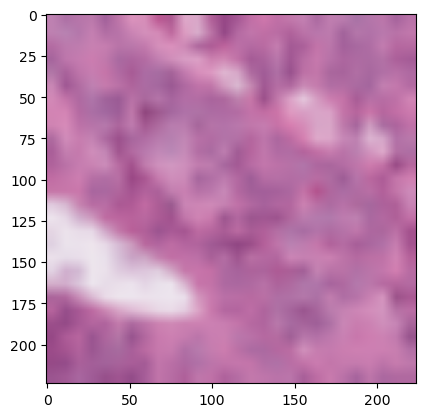

In [18]:
plt.imshow(example)

## Size 224

In [ ]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# TissueMNIST

In [42]:
data_flag = 'tissuemnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [43]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jbinda/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/jbinda/.medmnist/tissuemnist.npz


In [44]:
info

{'python_class': 'TissueMNIST',
 'description': 'We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.',
 'url': 'https://zenodo.org/records/10519652/files/tissuemnist.npz?download=1',
 'MD5': 'ebe78ee8b05294063de985d821c1c34b',
 'url_64': 'https://zenodo.org/records/10519652/files/tissuemnist_64.npz?download=1',
 'MD5_64': '123ece2eba09d0aa5d698fda57103344',
 'url_128': 'https://zenodo.org/records/10519652/files/tissuemnist_128.npz?download=1',
 'MD5_128': '61b955355d7425a89687b06cca3ce0c2',
 'url_224': 'https://zenodo.org/records/10519652/files/tissuemnist_224.npz?download=1',
 'MD5_224': 'b0

In [45]:
imgs = []
for i in range(len(train_dataset)):
    imgs.append(train_dataset[i][0])
imgs=torch.stack(imgs)

In [46]:
imgs.shape

torch.Size([165466, 1, 28, 28])

In [47]:
mean=torch.mean(imgs, dim=(0,2,3))
mean.shape

torch.Size([1])

In [83]:
batch = next(iter(train_loader))

In [85]:
batch[0].shape

torch.Size([128, 1, 28, 28])

In [104]:
pics = batch[0][21][0]

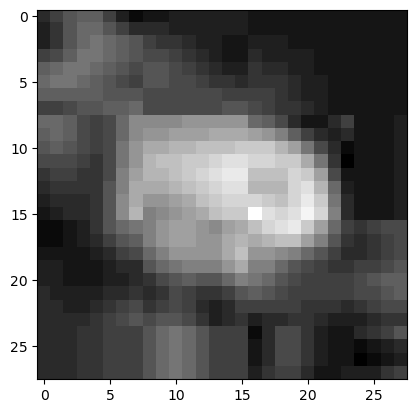

In [105]:
plt.imshow(pics, cmap="gray")

# NoduleMNIST3D

In [48]:
data_flag = "nodulemnist3d"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [49]:
info

{'python_class': 'NoduleMNIST3D',
 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/nodulemnist3d.npz?download=1',
 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3',
 'url_64': 'https://zenodo.org/records/10519652/files/nodulemnist3d_64.npz?download=1',
 'MD5_64': 'c47c5b7d457bf6332200d2ea6d64ecd8',
 'task': 'binary-class',
 'label': {'0': 'benign', '1': 'malignant'},
 'n_channels': 1,
 'n_samples': {

In [50]:
# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jbinda/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/jbinda/.medmnist/nodulemnist3d.npz


In [52]:
imgs=[]
for i in range(len(train_dataset)):
    imgs.append(torch.tensor(train_dataset[i][0]))
imgs=torch.stack(imgs)
imgs.shape

torch.Size([1158, 1, 28, 28, 28])

In [57]:
batch = next(iter(train_loader))

In [77]:
crop = batch[0][6][0]

In [78]:
crop.shape

torch.Size([28, 28, 28])

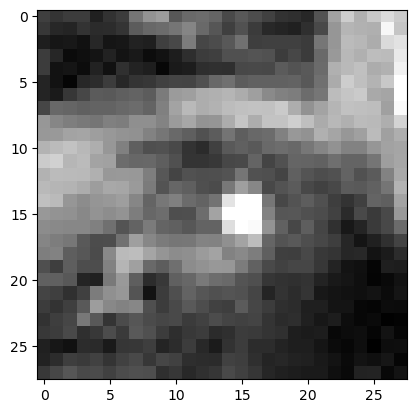

In [79]:
plt.imshow(crop[14,:,:], cmap='gray')

# Trash

## Dataset

In [7]:
from medmnist_dataset import get_medmnist_dataset, DataFlag

In [8]:
dataset = get_medmnist_dataset(
    data_flag=DataFlag.NODULEMNIST3D,
    mode="train",
    data_transform=None,
    size=28,
    download=True,
    mmap_mode=None
)

print(dataset)


Using downloaded and verified file: /home/jbinda/.medmnist/nodulemnist3d.npz
Dataset NoduleMNIST3D of size 28 (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /home/jbinda/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License: C

In [11]:
dataset[0][0].shape

(1, 28, 28, 28)

In [6]:
ds_MM = Dataset_MedMNIST(mode="train", data_flag=DataFlag.PATHMNIST, size=28)

In [7]:
ds = ds_MM.get_dataset()

In [8]:
img = ds[10]

In [9]:
plt.imshow(img[0])

NameError: name 'plt' is not defined

In [34]:
ds_MM.get_info()

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

## DataModule

In [1]:
from data_module import DataModule
from medmnist_dataset import DataFlag

In [2]:
dm = DataModule(data_flag=DataFlag.PATHMNIST)

In [3]:
dm.prepare_data()

Using downloaded and verified file: /home/jbinda/.medmnist/pathmnist.npz


In [4]:
dm.setup()

In [5]:
loader = dm.train_dataloader()

In [6]:
batch = next(iter(loader))

In [7]:
img = batch[0][0]

In [8]:
img

tensor([[[0.7333, 0.7451, 0.7373,  ..., 0.7961, 0.8039, 0.8471],
         [0.6353, 0.5451, 0.6627,  ..., 0.6863, 0.7333, 0.7882],
         [0.6549, 0.5490, 0.7922,  ..., 0.7961, 0.8000, 0.8118],
         ...,
         [0.8000, 0.6902, 0.7529,  ..., 0.6196, 0.7255, 0.7882],
         [0.8118, 0.6824, 0.6157,  ..., 0.8078, 0.8314, 0.8275],
         [0.8039, 0.7686, 0.6275,  ..., 0.8471, 0.8392, 0.7294]],

        [[0.4078, 0.4275, 0.4235,  ..., 0.4314, 0.4706, 0.5333],
         [0.3294, 0.2824, 0.3686,  ..., 0.3804, 0.4353, 0.4941],
         [0.3569, 0.2902, 0.5137,  ..., 0.4510, 0.4745, 0.4980],
         ...,
         [0.5098, 0.4275, 0.4471,  ..., 0.3216, 0.3922, 0.4392],
         [0.4902, 0.4157, 0.3804,  ..., 0.4196, 0.4392, 0.4392],
         [0.4784, 0.4510, 0.3647,  ..., 0.4824, 0.4784, 0.3922]],

        [[0.6275, 0.6510, 0.6471,  ..., 0.6510, 0.6824, 0.7294],
         [0.5686, 0.5294, 0.6000,  ..., 0.6157, 0.6549, 0.6902],
         [0.5882, 0.5294, 0.7059,  ..., 0.6667, 0.6824, 0.

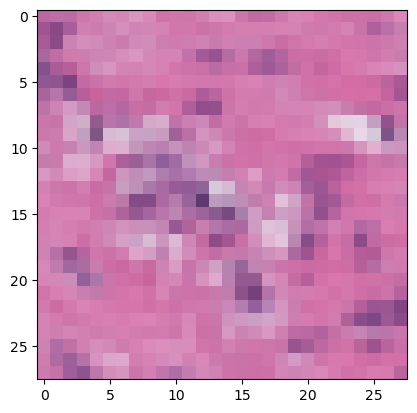

In [9]:
import matplotlib.pyplot as plt
import torch
img = torch.movedim(img, 0, 2)
plt.imshow(img)